In [1]:
##########
## Importing the required packages here
import pandas as pd
from copy import deepcopy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import warnings
from sklearn.metrics import roc_auc_score
import tqdm as notebook_tqdm
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback
import optuna
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import pickle
import shap
from h2o.estimators import H2OTargetEncoderEstimator
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1500)
from sklearn.linear_model import LogisticRegression
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

c:\users\navya\ml-spring-23\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [3]:
# Data Loading and Cleaning
df = pd.read_csv("SBA_loans_project_2.zip")

In [4]:
df.head(5)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,MIS_Status
0,0,PRINCETON,MN,55371,PEOPLES BANK OF COMMERCE,MN,441120,4,2.0,0,0,1,0,N,N,"$114,577.00",$0.00,"$114,577.00","$85,933.00",1,0
1,1,Kansas city,MO,64116,BANK OF HAYS,KS,481111,14,1.0,0,14,0,1,N,N,"$25,000.00",$0.00,"$25,000.00","$12,500.00",7,0
2,2,BELLWOOD,PA,16617,FIRST COMMONWEALTH BANK,PA,334417,10,1.0,0,2,1,1,0,N,"$85,000.00",$0.00,"$85,000.00","$42,500.00",4,0
3,3,GRAND PRAIRIE,TX,75050,PROSPERITY BANK,TX,0,18,1.0,0,0,1,0,N,N,"$230,000.00",$0.00,"$230,000.00","$195,500.00",5,0
4,4,EL PASO,TX,79925,WESTSTAR BANK,TX,423220,4,1.0,0,4,0,1,N,N,"$32,000.00",$0.00,"$32,000.00","$16,000.00",9,0


In [5]:
#Understanding the Size and Distribution of target variable to check if data is Balanced or otherwise.
(df['MIS_Status'].value_counts()) / len(df) * 100

0    82.438293
1    17.561707
Name: MIS_Status, dtype: float64

In [6]:
df.columns

Index(['index', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv',
       'SBA_Appv', 'LoanInd', 'MIS_Status'],
      dtype='object')

In [7]:
sba=df.head(600000)
sba.shape

(600000, 21)

In [8]:
(sba['MIS_Status'].value_counts()) / len(sba) * 100

0    82.429333
1    17.570667
Name: MIS_Status, dtype: float64

In [9]:
# Removing unnecessary data columns from the original dataset and storing the target variable
target=sba['MIS_Status']
target_var='MIS_Status'
drop_from_data=['index','RevLineCr','NoEmp','City','RetainedJob']
sba=sba.drop(columns=drop_from_data, axis=1)

In [10]:
## Storing the original columns that should be subset for training and validating and perform various encodings on
data_cols=sba.drop(columns=['MIS_Status']).columns
data_cols

Index(['State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NewExist', 'CreateJob',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       'BalanceGross', 'GrAppv', 'SBA_Appv', 'LoanInd'],
      dtype='object')

In [11]:
describe_more(sba)

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,State,51,object,2,3,"{'CA': 87484, 'TX': 47099, 'NY': 38363, 'FL': ..."
1,Zip,30437,int64,1,5,"{90015: 655, 10001: 618, 93401: 517, 90010: 48..."
2,Bank,5432,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 58205, 'WELLS F..."
3,BankState,56,object,2,3,"{'CA': 79162, 'NC': 53253, 'IL': 44234, 'OH': ..."
4,NAICS,1300,int64,1,6,"{0: 134888, 722110: 18738, 722211: 12882, 8111..."
5,NewExist,3,float64,3,3,"{1.0: 430548, 2.0: 168687, 0.0: 670}"
6,CreateJob,220,int64,1,4,"{0: 420059, 1: 42184, 2: 38355, 3: 19211, 4: 1..."
7,FranchiseCode,2468,int64,1,5,"{1: 426215, 0: 139088, 78760: 2299, 68020: 128..."
8,UrbanRural,3,int64,1,1,"{1: 313752, 0: 215962, 2: 70286}"
9,LowDoc,8,object,1,3,"{'N': 522158, 'Y': 73876, '0': 1018, 'C': 498,..."


In [12]:
# # Drop the rows corresponding to null values in the target column
sba=sba.dropna(subset=['MIS_Status'])

In [13]:
sba.groupby(by='MIS_Status')['MIS_Status'].count()

MIS_Status
0    494576
1    105424
Name: MIS_Status, dtype: int64

In [14]:
# removed '$' from columns values starting with '$'
col_remove_dollar = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
for col in col_remove_dollar:
    sba[col] = sba[col].str.replace('$','',regex=True).replace(',','',regex=True)
    sba[col] = sba[col].astype(float)

# Dataset Preparation and Clean-up

In [15]:
sba.isnull().sum()

State                  10
Zip                     0
Bank                  982
BankState             987
NAICS                   0
NewExist               95
CreateJob               0
FranchiseCode           0
UrbanRural              0
LowDoc               1669
DisbursementGross       0
BalanceGross            0
GrAppv                  0
SBA_Appv                0
LoanInd                 0
MIS_Status              0
dtype: int64

In [16]:
sba.groupby(by=["LowDoc"])["LowDoc"].count()

LowDoc
0      1018
1         1
A       330
C       498
N    522158
R        51
S       399
Y     73876
Name: LowDoc, dtype: int64

In [17]:
#drop the rows corresponding to null values of the following columns null values 
sba=sba.dropna(subset=['LowDoc','BankState','State','NewExist'])

In [18]:
# Convert LowDoc to Category
sba['LowDoc']=sba['LowDoc'].astype('category',copy=True)

In [19]:
sba.groupby(by=["UrbanRural"])["UrbanRural"].count()

UrbanRural
0    214974
1    312376
2     69891
Name: UrbanRural, dtype: int64

In [20]:
# # Convert UrbanRural to Category and encode 1 as Urban ,2 as Rural and 0 as Undefined
sba['UrbanRural']=sba['UrbanRural'].apply(lambda x: 'Urban' if x == 1 else  'Rural' if x==2 else 'Undefined')
sba['UrbanRural']=sba['UrbanRural'].astype('category',copy=True)

In [21]:
# # Convert FranchiseCode to to category
sba['FranchiseCode']=sba['FranchiseCode'].apply(lambda x: 'N' if x in [0,1] else 'Y')
sba['FranchiseCode'] = sba['FranchiseCode'].astype('category',copy=False)

In [22]:
# Adding New Features
# Get the frequency of each industry using frequency encoding 
sba['NAICS'] = sba['NAICS']%100
sba['NAICS'] = sba['NAICS'].astype('category',copy=False)

In [23]:
# calculate the net loan
sba['Net_Loan']=sba['DisbursementGross']-sba['BalanceGross']

# calculate the risk percentage that SBA bears on each loan provided
sba['SBA_Payable']=(sba['SBA_Appv']/sba['GrAppv'])

In [24]:
## Adding interaction between CreateJob and GrAppv
sba['Jobs_Loan']=(sba['CreateJob']*sba['GrAppv'])

In [25]:
## Adding interaction between GrAppv and DisbursementGross
sba['AppvGross']=(sba['GrAppv']*sba['DisbursementGross'])

In [26]:
## Create new column "Loan_history"
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
sba['NewExist_encoded'] = le.fit_transform(sba['NewExist'])
sba['loan_history'] = sba['DisbursementGross'] * sba['NewExist_encoded']
sba=sba.drop(columns=['NewExist_encoded'])

In [27]:
## Creating the Loan_history column
sba['UrbanRural_encoded'] = le.fit_transform(sba['UrbanRural'])
sba['loan_history'] = sba['DisbursementGross'] * sba['UrbanRural_encoded']
sba=sba.drop(columns=['UrbanRural_encoded'])

In [28]:
## Create a new feature "LoanLimit"
sba['LoanLimit']=(sba['LoanInd']*sba['DisbursementGross'])

In [29]:
## Converting Zip to a categorical variable
sba['Zip'] = sba['Zip'].astype(str)

# Splitting the data and Encoding

In [30]:
# # Train test valid split before encoding is performed. This is done before encoding to avoid data leakage.
X=sba
Y=sba['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X,Y,
    test_size=0.2, shuffle = True, random_state = 42,stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 42,stratify=y_train)

In [31]:
#Storing the Categorical columns for use in the later parts of the code
categorical_columns=['LowDoc','UrbanRural','FranchiseCode','NewExist']

In [32]:
# store the categorical and numerical columns seperately
cols_numerical_orig=[]
woe_te_cols=[]
for col in X_train.drop(columns=['MIS_Status','LowDoc','UrbanRural','FranchiseCode','NewExist']).columns:
    if pd.api.types.is_numeric_dtype(X_train[col].dtype):
        print('Column to process:', col)
        cols_numerical_orig.append(col)
    else:
        woe_te_cols.append(col)

Column to process: CreateJob
Column to process: DisbursementGross
Column to process: BalanceGross
Column to process: GrAppv
Column to process: SBA_Appv
Column to process: LoanInd
Column to process: Net_Loan
Column to process: SBA_Payable
Column to process: Jobs_Loan
Column to process: AppvGross
Column to process: loan_history
Column to process: LoanLimit


In [33]:
# # Perform one hot encoding on the categorical variables with less than 10 levels
ohe_columns=[]
for col in X_train.drop(columns=['MIS_Status']).columns:
    if X_train[col].dtype == 'category':
        if X_train[col].nunique() < 10:
            one_hot_enc = pd.get_dummies(X_train[col], prefix=col)
            X_train = pd.concat([X_train, one_hot_enc], axis=1)
            one_hot_enc_val=pd.get_dummies(X_val[col], prefix=col)
            X_val = pd.concat([X_val, one_hot_enc_val], axis=1)
            one_hot_enc_tst=pd.get_dummies(X_test[col], prefix=col)
            X_test = pd.concat([X_test, one_hot_enc_tst], axis=1)
            ohe_columns.extend(one_hot_enc)

In [34]:
#WOE encoding on categorical variables with more than 10 levels
woe_encoder = ce.WOEEncoder(cols=woe_te_cols)
woe_encoder.fit(X_train[woe_te_cols],X_train['MIS_Status'])
woe_enc_train = woe_encoder.transform(X_train[woe_te_cols])
woe_enc_test = woe_encoder.transform(X_test[woe_te_cols])
woe_enc_valid = woe_encoder.transform(X_val[woe_te_cols])
woe_columns = []
for col in woe_te_cols:
    X_train[col+"_woe"] = woe_enc_train[col]
    X_test[col+"_woe"] = woe_enc_test[col]
    X_val[col+"_woe"] = woe_enc_valid[col]
    woe_columns.append(col+"_woe")
X_val.head(5)

,State,Zip,Bank,BankState,NAICS,NewExist,CreateJob,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,MIS_Status,Net_Loan,SBA_Payable,Jobs_Loan,AppvGross,loan_history,LoanLimit,FranchiseCode_N,FranchiseCode_Y,UrbanRural_Rural,UrbanRural_Undefined,UrbanRural_Urban,LowDoc_0,LowDoc_1,LowDoc_A,LowDoc_C,LowDoc_N,LowDoc_R,LowDoc_S,LowDoc_Y,State_woe,Zip_woe,Bank_woe,BankState_woe,NAICS_woe
364744,CA,94538,BANK OF AMERICA CALIFORNIA N.A,CA,0,1.0,0,N,Undefined,N,150000.0,0.0,150000.0,105000.0,7,0,150000.0,0.70,0.0,2.250000e+10,150000.0,1050000.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0.071117,0.194754,-0.834207,0.263412,-0.838261
444539,VA,22020,BRANCH BK. & TR CO,VA,12,2.0,0,N,Undefined,Y,63000.0,0.0,63000.0,56700.0,2,0,63000.0,0.90,0.0,3.969000e+09,63000.0,126000.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.068936,-0.936648,-0.571663,1.078841,0.193515
261189,NY,11374,JPMORGAN CHASE BANK NATL ASSOC,IL,10,1.0,0,N,Urban,N,19800.0,0.0,19800.0,9900.0,7,1,19800.0,0.50,0.0,3.920400e+08,39600.0,138600.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.151865,0.855111,0.557701,0.277391,0.022039
370316,MA,2343,BANK OF AMERICA NATL ASSOC,NC,90,2.0,1,N,Urban,N,5000.0,0.0,5000.0,2500.0,4,0,5000.0,0.50,5000.0,2.500000e+07,10000.0,20000.0,1,0,0,0,1,0,0,0,0,1,0,0,0,-0.361514,-0.611226,0.584833,0.673879,0.492180
576241,LA,70058,BBCN BANK,CA,20,2.0,2,N,Urban,N,10000.0,0.0,10000.0,8500.0,5,1,10000.0,0.85,20000.0,1.000000e+08,20000.0,50000.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.005668,0.709929,1.727571,0.263412,0.270891


In [35]:
# target encoding on categorical variables with more than 10 levels
TEenc = TargetEncoder()
encoder_te = TEenc.fit(X_train[woe_te_cols],y_train )
train_enc_te= encoder_te.transform(X_train[woe_te_cols])
test_enc_te=encoder_te.transform(X_test[woe_te_cols])
val_enc_te=encoder_te.transform(X_val[woe_te_cols])
for col in woe_te_cols:
    X_train[col+"_te"] = train_enc_te[col]
    X_test[col+"_te"] = test_enc_te[col]
    X_val[col+"_te"] = val_enc_te[col]

In [36]:
# Scale the data using standard scalar
for col in X_train[cols_numerical_orig]:
    scaler = StandardScaler()
    scaler.fit(X_train[[col]])
    X_train[col+"_sc"] = scaler.transform(X_train[[col]])
    X_val[col+"_sc"] = scaler.transform(X_val[[col]])
    X_test[col+"_sc"] = scaler.transform(X_test[[col]])

In [37]:
X_train.columns

Index(['State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NewExist', 'CreateJob',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       'BalanceGross', 'GrAppv', 'SBA_Appv', 'LoanInd', 'MIS_Status',
       'Net_Loan', 'SBA_Payable', 'Jobs_Loan', 'AppvGross', 'loan_history',
       'LoanLimit', 'FranchiseCode_N', 'FranchiseCode_Y', 'UrbanRural_Rural',
       'UrbanRural_Undefined', 'UrbanRural_Urban', 'LowDoc_0', 'LowDoc_1',
       'LowDoc_A', 'LowDoc_C', 'LowDoc_N', 'LowDoc_R', 'LowDoc_S', 'LowDoc_Y',
       'State_woe', 'Zip_woe', 'Bank_woe', 'BankState_woe', 'NAICS_woe',
       'State_te', 'Zip_te', 'Bank_te', 'BankState_te', 'NAICS_te',
       'CreateJob_sc', 'DisbursementGross_sc', 'BalanceGross_sc', 'GrAppv_sc',
       'SBA_Appv_sc', 'LoanInd_sc', 'Net_Loan_sc', 'SBA_Payable_sc',
       'Jobs_Loan_sc', 'AppvGross_sc', 'loan_history_sc', 'LoanLimit_sc'],
      dtype='object')

In [38]:
columns_woe=['State_woe','Bank_woe','BankState_woe','NAICS_woe','Zip_woe']
columns_te=['State_te','Bank_te','BankState_te','NAICS_te','Zip_woe']

In [40]:
orig=['DisbursementGross', 'BalanceGross', 'GrAppv','SBA_Appv', 'LoanInd','FranchiseCode_N','FranchiseCode_Y','UrbanRural_Rural',
 'UrbanRural_Undefined','UrbanRural_Urban','LowDoc_N','LowDoc_Y', 'LowDoc_R','LowDoc_S', 'LowDoc_0',
 'LowDoc_1','LowDoc_A','LowDoc_C']

# Model 1 LightGBM on WOE unscaled data with new features

In [41]:
# Segregate the parameters on woe encoded unscaled data 
X_tr = X_train[columns_woe+cols_numerical_orig+ohe_columns]
Y_tr = y_train
X_tst = X_test[columns_woe+cols_numerical_orig+ohe_columns]
Y_tst = y_test
X_v = X_val[columns_woe+cols_numerical_orig+ohe_columns]
Y_v = y_val

In [42]:
parameters=X_tr.columns
parameters

Index(['State_woe', 'Bank_woe', 'BankState_woe', 'NAICS_woe', 'Zip_woe',
       'CreateJob', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv',
       'LoanInd', 'Net_Loan', 'SBA_Payable', 'Jobs_Loan', 'AppvGross',
       'loan_history', 'LoanLimit', 'FranchiseCode_N', 'FranchiseCode_Y',
       'UrbanRural_Rural', 'UrbanRural_Undefined', 'UrbanRural_Urban',
       'LowDoc_0', 'LowDoc_1', 'LowDoc_A', 'LowDoc_C', 'LowDoc_N', 'LowDoc_R',
       'LowDoc_S', 'LowDoc_Y'],
      dtype='object')

In [43]:
#Implement Light GBM on Unscaled WOE Encoded Data
import lightgbm as lgb
train_data = lgb.Dataset(data=X_tr, label=Y_tr, params={"verbose":-1})
test_data = lgb.Dataset(data=X_v, label=Y_v, params={"verbose":-1})
lgb_clf = lgb.train(params={"verbose":-1},train_set=train_data)

In [44]:
#AUC for the train and validation data
print("AUC score on Vaidation dataset:", roc_auc_score(Y_v, lgb_clf.predict(X_v)))
print("AUC score on Train dataset:", roc_auc_score(Y_tr, lgb_clf.predict(X_tr)))

AUC score on Vaidation dataset: 0.7860445208170801
AUC score on Train dataset: 0.8359192229688142


In [45]:
## Setting the default threshold, calculate the F1 score
y_pred_prob_tr1 = lgb_clf.predict(X_tr)
y_pred_tr1 = (y_pred_prob_tr1 > 0.5).astype(int)
f1_train1 = f1_score(Y_tr, y_pred_tr1,average='macro')
print("F1 score on train data:", f1_train1)

y_pred_prob_v1 = lgb_clf.predict(X_v)
y_pred_v1 = (y_pred_prob_v1 > 0.5).astype(int)
f1_val1 = f1_score(Y_v, y_pred_v1,average='macro')
print("F1 score on validation data:", f1_val1)

F1 score on train data: 0.6652309485293958
F1 score on validation data: 0.6238695276299513


In [46]:
#Confusion Matrix on the Validation data
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(Y_v, y_pred_v1)
print("Confusion matrix:")
print(cm1)

Confusion matrix:
[[95209  3296]
 [15984  4959]]


# Model 2 LightGBM on TE columns

In [47]:
# Segregate the data for Target encoded unscaled data 
X_tr_te = X_train[columns_te+cols_numerical_orig+ohe_columns]
Y_tr_te = y_train
X_tst_te = X_test[columns_te+cols_numerical_orig+ohe_columns]
Y_tst_te = y_test
X_v_te = X_val[columns_te+cols_numerical_orig+ohe_columns]
Y_v_te = y_val

In [48]:
# Train a light gbm model and target encoded columns
train_data_te = lgb.Dataset(data=X_tr_te, label=Y_tr_te, params={"verbose":-1})
test_data_te = lgb.Dataset(data=X_v_te, label=Y_v_te, params={"verbose":-1})
lgb_clf_te = lgb.train(params={"verbose":-1},train_set=train_data_te)

In [49]:
print("AUC score on Validation dataset:", roc_auc_score(Y_v_te, lgb_clf_te.predict(X_v_te)))
print("AUC score on Train dataset:", roc_auc_score(Y_tr_te, lgb_clf_te.predict(X_tr_te)))

AUC score on Validation dataset: 0.7857713947033917
AUC score on Train dataset: 0.8359405437215796


In [50]:
y_pred_prob_tr2 = lgb_clf_te.predict(X_tr_te)
y_pred_tr2 = (y_pred_prob_tr2 > 0.5).astype(int)
f1_train2 = f1_score(Y_tr_te, y_pred_tr2,average='macro')
print("F1 score on train data:", f1_train2)

y_pred_prob_v2 = lgb_clf_te.predict(X_v_te)
y_pred_v2 = (y_pred_prob_v2 > 0.5).astype(int)
f1_val2 = f1_score(Y_v_te, y_pred_v2,average='macro')
print("F1 score on validation data:", f1_val2)

F1 score on train data: 0.6630838703145185
F1 score on validation data: 0.6212701360098759


# Model with Scaled Data and WOE Encoding

In [51]:
## Storing the scaled columns in the list "scaled"
scaled=['DisbursementGross_sc', 'BalanceGross_sc', 'GrAppv_sc',
       'SBA_Appv_sc', 'LoanInd_sc', 'Net_Loan_sc','Jobs_Loan', 'SBA_Payable_sc','AppvGross', 'loan_history_sc', 'LoanLimit_sc']

In [52]:
# Segregate the data for woe encoded scaled data 
X_tr_sc = X_train[columns_woe+scaled+ohe_columns]
Y_tr_sc = y_train
X_tst_sc = X_test[columns_woe+scaled+ohe_columns]
Y_tst_sc = y_test
X_v_sc = X_val[columns_woe+scaled+ohe_columns]
Y_v_sc = y_val

In [53]:
## train a light gbm for woe encoded scaled data
train_data_sc = lgb.Dataset(data=X_tr_sc, label=Y_tr_sc, params={"verbose":-1})
test_data_sc = lgb.Dataset(data=X_v_sc, label=Y_v_sc, params={"verbose":-1})
lgb_clf_sc = lgb.train(params={"verbose":-1},train_set=train_data_sc)

In [54]:
## Check the AUC and F1 scores

print("AUC score on Test dataset:", roc_auc_score(Y_v_sc, lgb_clf_sc.predict(X_v_sc)))
print("AUC score on Validation dataset:", roc_auc_score(Y_tr_sc, lgb_clf_sc.predict(X_tr_sc)))
y_pred_prob_sc = lgb_clf_sc.predict(X_tr_sc)
y_pred_sc = (y_pred_prob_sc > 0.5).astype(int)
f1_train_sc = f1_score(Y_tr_sc, y_pred_sc,average='macro')
print("F1 score on train data:", f1_train_sc)

y_pred_prob_sc_tst = lgb_clf_sc.predict(X_v_sc)
y_pred_sc = (y_pred_prob_sc_tst > 0.5).astype(int)
f1_val_sc = f1_score(Y_v_sc, y_pred_sc,average='macro')
print("F1 score on validation data:", f1_val_sc)

AUC score on Test dataset: 0.7851388999438371
AUC score on Validation dataset: 0.8356020840053112
F1 score on train data: 0.6635349951150672
F1 score on validation data: 0.6216012484462076


In [ ]:
""" We observe that all the three models nearly provided the same F1 score. Scaling does not impact the lightgbm results as decision trees are not 
affected by the scale of the data.
"""

# Model tuning for LightGBM

In [101]:
# # The following is the optuna technique for hyperparameter tuning.

warnings.filterwarnings("ignore", category=UserWarning)
study_model_iteractions = {}
def objective(trial, X, y):
    param_grid = {
        ############################Parameters for best accuracy
      "num_iterations": 10000,# Should be high
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.8, step=0.05),# should be low but should be modified as num_iterations
        "num_leaves": trial.suggest_int("num_leaves", 50, 100, step=5),
        "max_depth": trial.suggest_int("max_depth", 5, 20, step=2),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 1000, step=100),
        ############################## Parameters to control overfitting
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),# Acts as a regularisation on the trees
        ########################
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.8, 1.0, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [5]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1.0, step=0.1),
        #######################
        "is_unbalance": trial.suggest_categorical("is_unbalance",[True, False]),
        ########################
        "verbose": -1,
        "objective":"binary",
        "metric":"auc"
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)
    cv_scores = np.empty(5)
    cv_iteractions = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

        train_data = lgb.Dataset(data=X_train, label=y_train, params={"verbose":-1})
        valid_data = lgb.Dataset(data=X_valid, label=y_valid, params={"verbose":-1})
        lgb_clf = lgb.train(params=param_grid,
                            train_set=train_data,
                            valid_sets=[valid_data],
                            callbacks=[LightGBMPruningCallback(trial, "auc"),
                                        lgb.early_stopping(stopping_rounds=5)]  
                            )
        preds = lgb_clf.predict(X_valid)
        cv_scores[idx] = roc_auc_score(y_valid, preds)
        cv_iteractions[idx] = lgb_clf.best_iteration
    
    study_model_iteractions[trial.number] = np.mean(cv_iteractions)

    return np.mean(cv_scores)

In [102]:
## Create an optuna study that runs over the trials of each parameter from the tuning space.
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_tr, Y_tr)
study.optimize(func, n_trials=200)

[I 2023-05-08 07:02:51,947] A new study created in memory with name: LGBM Classifier


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.830497
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's auc: 0.831611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.833674
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.833852
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:02:57,757] Trial 0 finished with value: 0.8325920465988481 and parameters: {'learning_rate': 0.45000000000000007, 'num_leaves': 65, 'max_depth': 15, 'min_data_in_leaf': 800, 'lambda_l2': 5.3333813746439866e-05, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 0 with value: 0.8325920465988481.


Early stopping, best iteration is:
[23]	valid_0's auc: 0.833327
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.832625
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.833483
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.834365
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.835932
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:03,577] Trial 1 finished with value: 0.8345563450400707 and parameters: {'learning_rate': 0.35, 'num_leaves': 80, 'max_depth': 13, 'min_data_in_leaf': 100, 'lambda_l2': 1.1523127572178644, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 1 with value: 0.8345563450400707.


Early stopping, best iteration is:
[34]	valid_0's auc: 0.836377
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.828117
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's auc: 0.828037
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.828626
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.831225
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:09,017] Trial 2 finished with value: 0.8294656725341266 and parameters: {'learning_rate': 0.75, 'num_leaves': 100, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l2': 0.00017880717116365843, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 1 with value: 0.8345563450400707.


Early stopping, best iteration is:
[38]	valid_0's auc: 0.831324
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:14,427] Trial 3 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.3360121086285849e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 1 with value: 0.8345563450400707.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.826952
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.82739
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.827268
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.830703
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:19,341] Trial 4 finished with value: 0.8284821816332422 and parameters: {'learning_rate': 0.75, 'num_leaves': 70, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l2': 1.1094085106502216e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': True}. Best is trial 1 with value: 0.8345563450400707.


Early stopping, best iteration is:
[26]	valid_0's auc: 0.830097


[I 2023-05-08 07:03:19,783] Trial 5 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:20,319] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:20,937] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:21,481] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:22,027] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:22,627] Trial 10 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.833582
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.833704
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.835719
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.836666
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:28,790] Trial 11 finished with value: 0.8351133407446529 and parameters: {'learning_rate': 0.35, 'num_leaves': 85, 'max_depth': 15, 'min_data_in_leaf': 700, 'lambda_l2': 0.0054173421760339985, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[35]	valid_0's auc: 0.835896
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:29,476] Trial 12 pruned. Trial was pruned at iteration 9.
[I 2023-05-08 07:03:29,979] Trial 13 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:30,767] Trial 14 pruned. Trial was pruned at iteration 9.
[I 2023-05-08 07:03:31,401] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:31,927] Trial 16 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:32,811] Trial 17 pruned. Trial was pruned at iteration 19.
[I 2023-05-08 07:03:33,381] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:33,849] Trial 19 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:34,306] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:34,811] Trial 21 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:35,269] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:35,796] Trial 23 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:36,292] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:36,830] Trial 25 pruned. Trial was pruned at iteration 3.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:37,327] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:37,867] Trial 27 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:38,350] Trial 28 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:38,797] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:39,319] Trial 30 pruned. Trial was pruned at iteration 3.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:44,510] Trial 31 finished with value: 0.8321471503330533 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.0372814395831787e-06, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:03:45,067] Trial 32 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:45,636] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:46,141] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:46,627] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:47,240] Trial 36 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:47,930] Trial 37 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:48,410] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:48,891] Trial 39 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:49,596] Trial 40 pruned. Trial was pruned at iteration 3.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:54,469] Trial 41 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.0378273839998143e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:03:54,987] Trial 42 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:55,489] Trial 43 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:56,049] Trial 44 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:03:56,536] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:57,004] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:57,467] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:57,987] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:58,491] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:03:58,977] Trial 50 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:04,777] Trial 51 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.4507900202533806e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:04:05,251] Trial 52 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:05,759] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:06,337] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:06,986] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:07,561] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:08,150] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:08,749] Trial 58 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:09,308] Trial 59 pruned. Trial was pruned at iteration 3.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:09,761] Trial 60 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:14,949] Trial 61 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.1204173087520436e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:04:15,406] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:16,039] Trial 63 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:16,687] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:17,259] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:17,789] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:18,319] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:18,911] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:19,449] Trial 69 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:19,959] Trial 70 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:24,778] Trial 71 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.0235329932821663e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:04:25,339] Trial 72 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:25,907] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:26,449] Trial 74 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:26,923] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:27,401] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:27,947] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:28,477] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:29,034] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:29,579] Trial 80 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:35,117] Trial 81 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 2.0683407321302114e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:04:35,707] Trial 82 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:36,361] Trial 83 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:36,860] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:37,377] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:37,922] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:38,447] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:39,012] Trial 88 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:39,538] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:40,071] Trial 90 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:44,994] Trial 91 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 2.6062175536490907e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:04:45,499] Trial 92 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:45,973] Trial 93 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:46,495] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:47,009] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:47,598] Trial 96 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:48,157] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:48,766] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:49,489] Trial 99 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:04:50,109] Trial 100 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:04:55,615] Trial 101 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.7348386274669834e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:04:56,161] Trial 102 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:01,288] Trial 103 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 5.4363082666681e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:05:01,737] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:02,249] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:02,720] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:03,249] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:03,779] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:04,370] Trial 109 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:04,991] Trial 110 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:10,589] Trial 111 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.6125633887501085e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:15,611] Trial 112 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.0090844929628666e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:05:16,147] Trial 113 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:16,669] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:17,157] Trial 115 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:17,629] Trial 116 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:18,189] Trial 117 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:18,713] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:19,177] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:19,646] Trial 120 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:25,150] Trial 121 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 4.962879717630928e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:05:25,657] Trial 122 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:26,172] Trial 123 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:26,712] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:27,277] Trial 125 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:27,817] Trial 126 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:28,387] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:28,986] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:29,454] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:29,919] Trial 130 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:37,668] Trial 131 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.4513619153932774e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:43,147] Trial 132 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.7636178700642397e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:48,231] Trial 133 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.0032375634779733e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:05:48,747] Trial 134 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:49,309] Trial 135 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:49,826] Trial 136 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:50,454] Trial 137 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:51,023] Trial 138 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:05:51,569] Trial 139 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:52,160] Trial 140 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:05:57,727] Trial 141 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.2147086930461067e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:02,537] Trial 142 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.08635885671476e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:06:03,061] Trial 143 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:03,575] Trial 144 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:04,125] Trial 145 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:04,597] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:05,069] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:05,637] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:06,267] Trial 149 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:06,799] Trial 150 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:12,548] Trial 151 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 4.420095905650228e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:06:13,197] Trial 152 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:13,819] Trial 153 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:14,387] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:15,007] Trial 155 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:15,671] Trial 156 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:16,254] Trial 157 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:16,889] Trial 158 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:17,477] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:18,096] Trial 160 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:18,642] Trial 161 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:23,467] Trial 162 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.6120857084532472e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:29,089] Trial 163 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.3289200005289395e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:06:29,609] Trial 164 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:30,123] Trial 165 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:30,614] Trial 166 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:31,076] Trial 167 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:31,547] Trial 168 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:32,077] Trial 169 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:32,581] Trial 170 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:37,499] Trial 171 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.6449581662338555e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:42,727] Trial 172 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.9587562851586142e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:06:43,267] Trial 173 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:43,951] Trial 174 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:44,530] Trial 175 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:44,997] Trial 176 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:45,590] Trial 177 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:46,156] Trial 178 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:46,620] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:47,111] Trial 180 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:51,871] Trial 181 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.3550327410686868e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:06:52,369] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:06:52,906] Trial 183 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:06:58,071] Trial 184 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 4.381531471595982e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:03,308] Trial 185 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.0268573648566355e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:07:03,909] Trial 186 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:04,487] Trial 187 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:05,012] Trial 188 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:07:05,591] Trial 189 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:06,127] Trial 190 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:10,929] Trial 191 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.670822054650517e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:16,470] Trial 192 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 1.4239815350495227e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.830692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.831158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.833904
Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:21,676] Trial 193 finished with value: 0.8321471503330489 and parameters: {'learning_rate': 0.5, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 200, 'lambda_l2': 3.1873494990070775e-08, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 11 with value: 0.8351133407446529.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.833824


[I 2023-05-08 07:07:22,276] Trial 194 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:22,870] Trial 195 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:23,511] Trial 196 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-08 07:07:24,069] Trial 197 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:07:24,597] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2023-05-08 07:07:25,101] Trial 199 pruned. Trial was pruned at iteration 0.


In [103]:
print(f"\tBest value (AUC): {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.83511
	Best params:
		learning_rate: 0.35
		num_leaves: 85
		max_depth: 15
		min_data_in_leaf: 700
		lambda_l2: 0.0054173421760339985
		bagging_fraction: 1.0
		bagging_freq: 5
		feature_fraction: 0.8
		is_unbalance: True


# Training Model With the best parameters (ScikitLearn)

In [ ]:
''' In the above optuna the following are the best parameters->
 Train the lgb model with the best parameters.'''

In [104]:
best_params = {"verbose": -1,"objective":"binary","metric":"auc","learning_rate": 0.35,"num_leaves": 85,"max_depth": 15,"min_data_in_leaf": 700,"lambda_l2":0.005,
              "bagging_fraction": 1.0,"bagging_freq": 5,"feature_fraction": 0.8,"is_unbalance": True}
train_data = lgb.Dataset(data=X_tr, label=Y_tr, params={"verbose":-1})
test_data = lgb.Dataset(data=X_v, label=Y_v, params={"verbose":-1})
best_lgb = lgb.train(params=best_params,train_set=train_data)


In [105]:
print("AUC score on Vaidation dataset:", roc_auc_score(Y_v, best_lgb.predict(X_v)))
print("AUC score on Train dataset:", roc_auc_score(Y_tr, best_lgb.predict(X_tr)))
y_pred_prob_tr_best = best_lgb.predict(X_tr)
y_pred_tr_best = (y_pred_prob_tr_best > 0.5).astype(int)
f1_train_best = f1_score(Y_tr, y_pred_tr_best,average='macro')
print("F1 score on train data:", f1_train_best)

y_pred_prob_v_best = best_lgb.predict(X_v)
y_pred_v_best = (y_pred_prob_v_best > 0.5).astype(int)
f1_val_best = f1_score(Y_v, y_pred_v_best,average='macro')
print("F1 score on validation data:", f1_val_best)

AUC score on Vaidation dataset: 0.7916491067796945
AUC score on Train dataset: 0.8727051800709247
F1 score on train data: 0.7022964578857906
F1 score on validation data: 0.6488150107459111


In [60]:
## Find the best threshold for the best model
fpr, tpr, thresholds = roc_curve(Y_v, y_pred_prob_v_best)
# Calculate index for the best probability threshold
best_f1 = 0
best_f1_id = 0
for id,threshold in enumerate(thresholds):
    f1 = f1_score(y_pred_prob_v_best >= threshold, Y_v,average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_f1_id = id
print("Best f1:", best_f1)
best_threshold = thresholds[best_f1_id]
print("Threshold for best F1:", best_threshold)

Best f1: 0.6825122103046143
Threshold for best F1: 0.675057299129902


In [61]:
# Confusion Matrix with best best f1
cm_best = confusion_matrix(Y_v, y_pred_v_best)
print("Confusion matrix:")
print(cm_best)

Confusion matrix:
[[72762 25743]
 [ 6468 14475]]


# GBM in h2o

In [62]:
import h2o
import numpy as np
import math
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.6+9-LTS-190, mixed mode, sharing)
  Starting server from C:\Users\navya\ml-spring-23\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\navya\AppData\Local\Temp\tmpspdqm3_v
  JVM stdout: C:\Users\navya\AppData\Local\Temp\tmpspdqm3_v\h2o_navya_started_from_python.out
  JVM stderr: C:\Users\navya\AppData\Local\Temp\tmpspdqm3_v\h2o_navya_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_navya_jm5u61
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.840 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [63]:
#Limit to 8 threads and 8GB memory
h2o.init(nthreads=8, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,17 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_navya_jm5u61
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.823 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [64]:
from h2o.frame import H2OFrame
# Loading the scikit-learn datasets
data=H2OFrame(sba)
cat_columns = ['NewExist','LowDoc','FranchiseCode','UrbanRural']
encoded_columns=['Bank','BankState','NAICS','State','Zip']
response ='MIS_Status'
data[encoded_columns+cat_columns+[response]] = data[encoded_columns+cat_columns+[response]].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [65]:
data.head(2)

State,Zip,Bank,BankState,NAICS,NewExist,CreateJob,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,MIS_Status,Net_Loan,SBA_Payable,Jobs_Loan,AppvGross,loan_history,LoanLimit
MN,55371,PEOPLES BANK OF COMMERCE,MN,20,2,0,N,Undefined,N,114577,0,114577,85933,1,0,114577,0.750002,0,1.31279e+10,114577,114577
MO,64116,BANK OF HAYS,KS,11,1,0,N,Urban,N,25000,0,25000,12500,7,0,25000,0.5,0,6.25e+08,50000,175000


In [66]:
# Split the data to train,test, valid
train,test,valid = data.split_frame(ratios=[.6, .2], seed=123)

In [67]:
# Store the columns to train as variables
variables=train.columns
variables

['State',
 'Zip',
 'Bank',
 'BankState',
 'NAICS',
 'NewExist',
 'CreateJob',
 'FranchiseCode',
 'UrbanRural',
 'LowDoc',
 'DisbursementGross',
 'BalanceGross',
 'GrAppv',
 'SBA_Appv',
 'LoanInd',
 'MIS_Status',
 'Net_Loan',
 'SBA_Payable',
 'Jobs_Loan',
 'AppvGross',
 'loan_history',
 'LoanLimit']

# Data Encoding

In [68]:
train.head(5)

State,Zip,Bank,BankState,NAICS,NewExist,CreateJob,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,MIS_Status,Net_Loan,SBA_Payable,Jobs_Loan,AppvGross,loan_history,LoanLimit
MN,55371,PEOPLES BANK OF COMMERCE,MN,20,2,0,N,Undefined,N,114577,0,114577,85933,1,0,114577,0.750002,0,1.31279e+10,114577,114577
MO,64116,BANK OF HAYS,KS,11,1,0,N,Urban,N,25000,0,25000,12500,7,0,25000,0.5,0,6.25e+08,50000,175000
PA,16617,FIRST COMMONWEALTH BANK,PA,17,1,0,N,Urban,N,85000,0,85000,42500,4,0,85000,0.5,0,7.225e+09,170000,340000
TX,79925,WESTSTAR BANK,TX,20,1,0,N,Urban,N,32000,0,32000,16000,9,0,32000,0.5,0,1.024e+09,64000,288000
IA,50658,FIRST NATIONAL BANK,IA,40,1,0,N,Undefined,N,150000,0,150000,112500,7,0,150000,0.75,0,2.25e+10,150000,1.05e+06


In [69]:
# Target Encoding in H2O
data_te = H2OTargetEncoderEstimator(#fold_column=fold_column,
                                    data_leakage_handling=None,
                                    blending=True,
                                    inflection_point=3,
                                    smoothing=10,
                                    noise=0.15,     # In general, the less data you have the more regularization you need
                                    seed=1234)

In [70]:
data_te.train(x=encoded_columns+cat_columns,
              y=response,
              training_frame=train)

# New target encoded dataset
train_te = data_te.transform(frame=train, as_training=True)
valid_te = data_te.transform(frame=valid, as_training=False)

predictors = train_te.columns
for col in cat_columns+encoded_columns+[response]:
    predictors.remove(col)

targetencoder Model Build progress: |████████████████████████████████████████████| (done) 100%


In [71]:
predictors

['State_te',
 'Zip_te',
 'Bank_te',
 'BankState_te',
 'NAICS_te',
 'NewExist_te',
 'FranchiseCode_te',
 'UrbanRural_te',
 'LowDoc_te',
 'CreateJob',
 'DisbursementGross',
 'BalanceGross',
 'GrAppv',
 'SBA_Appv',
 'LoanInd',
 'Net_Loan',
 'SBA_Payable',
 'Jobs_Loan',
 'AppvGross',
 'loan_history',
 'LoanLimit']

In [72]:
from h2o.estimators import H2OGradientBoostingEstimator
predictors_gbm = predictors
gbm_model = H2OGradientBoostingEstimator(ntrees = 10000,                                                            
  ## smaller learning rate is better (this is a good value for most datasets)
  learn_rate = 0.01,                                                         
  ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 
  ## sample 80% of rows per tree
  sample_rate = 0.8,                                                       
  ## sample 80% of columns per split
  col_sample_rate = 0.8,                                                   
  ## fix a random number generator seed for reproducibility
  seed = 1234,                                                             
  ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

gbm_model.train(x=predictors_gbm, y=response, training_frame=train_te)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1683523369905_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1530               1530                        641441                 0            5            4.78758       1             32            28.5503

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1084881789551734
RMSE: 0.32937543769257205
LogLoss: 0.34813584106080475
Mean Per-Class Error: 0.26883497368935244
AUC: 0.833908594145233
AUCPR: 0.5540542468760994
Gini: 0.667817188290466

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26421028240609484
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      252622  43185  0.146    (43185.0/295807.0)
1      24695   38354  0.3917   (24695.0/63049.0)
Total  277317  81539  0.1892   (67880.0/358856.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.26421      0.530528  216
max f2                       0.125359     0.647824  297
max f0point5                 0.441395     0.543875  136
max accuracy                 0.484913     0.850595  121
max precision                0.990288     1         0
max recall                   0.0105416    1         391
max specificity              0.990288     1         0
max absolute_mcc             0.290739     0.421567  202
max min_per_class_accuracy   0.180412     0.750195  262
max mean_per_class_accuracy  0.178942     0.750732  263
max tns                      0.990288     295807    0
max fns                      0.990288     63047     0
max fps                      0.00196453   295807    399
max tps                      0.0105416    63049     391
max tnr                      0.990288     1         0
max fnr                      0.990288     0.999968  0
max fpr                      0.00196453   1         399
max tpr                      0.0105416    1         391

Gains/Lift Table: Avg response rate: 17.57 %, avg score: 17.57 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100012                   0.794759           5.14933     5.14933            0.904709         0.851411   0.904709                    0.851411            0.0514996       0.0514996                  414.933   414.933            0.0503435
2        0.0200025                   0.720056           4.5134      4.83136            0.792979         0.755331   0.848844                    0.803371            0.0451395       0.0966391                  351.34    383.136            0.0929712
3        0.0300009                   0.662352           4.1149      4.59259            0.722965         0.689888   0.806892                    0.76555             0.0411426       0.137782                   311.49    359.259            0.130753
4        0.0400021                   0.615713           3.81878     4.39912            0.670939         0.638292   0.772901                    0.733734            0.0381925       0.175974                   281.878   339.912            0.164954
5        0.0500006                   0.576114           3.52321     4.22397            0.619008        

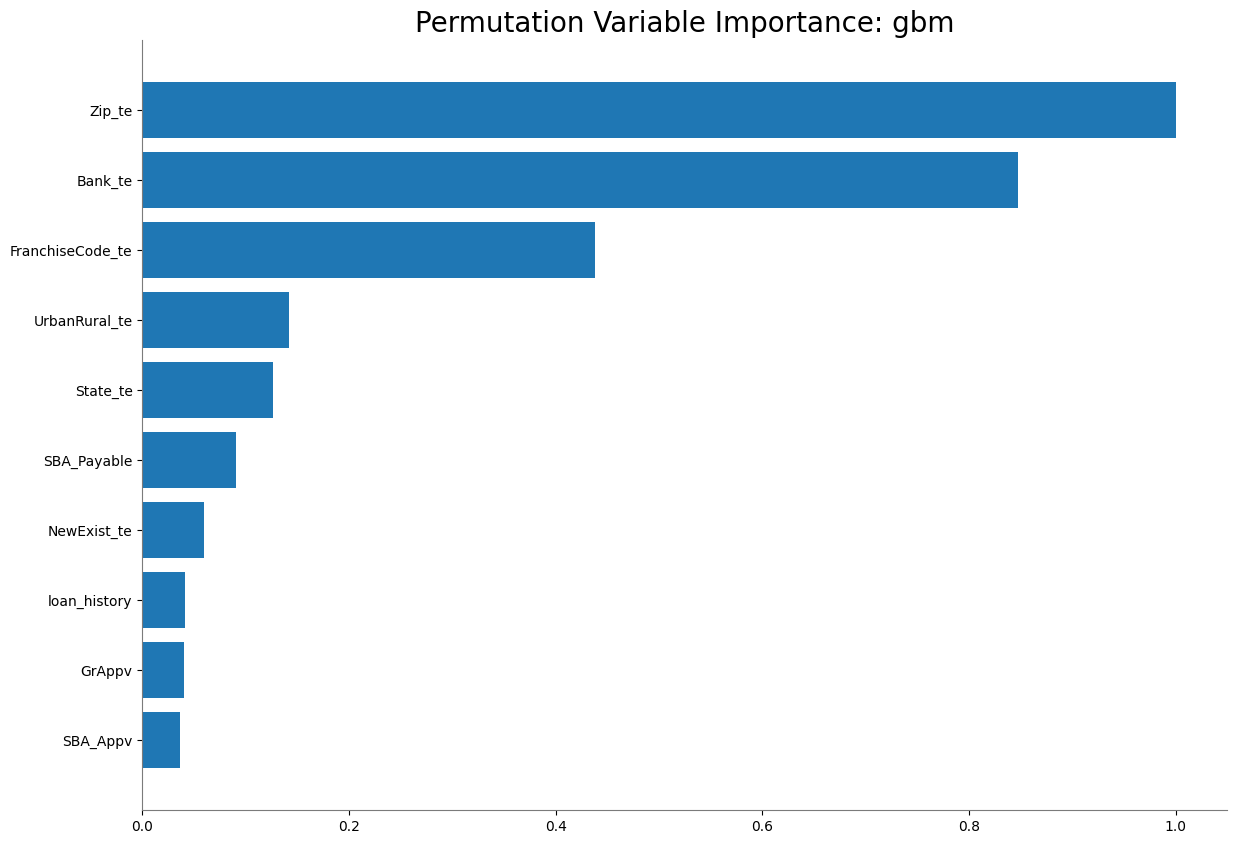

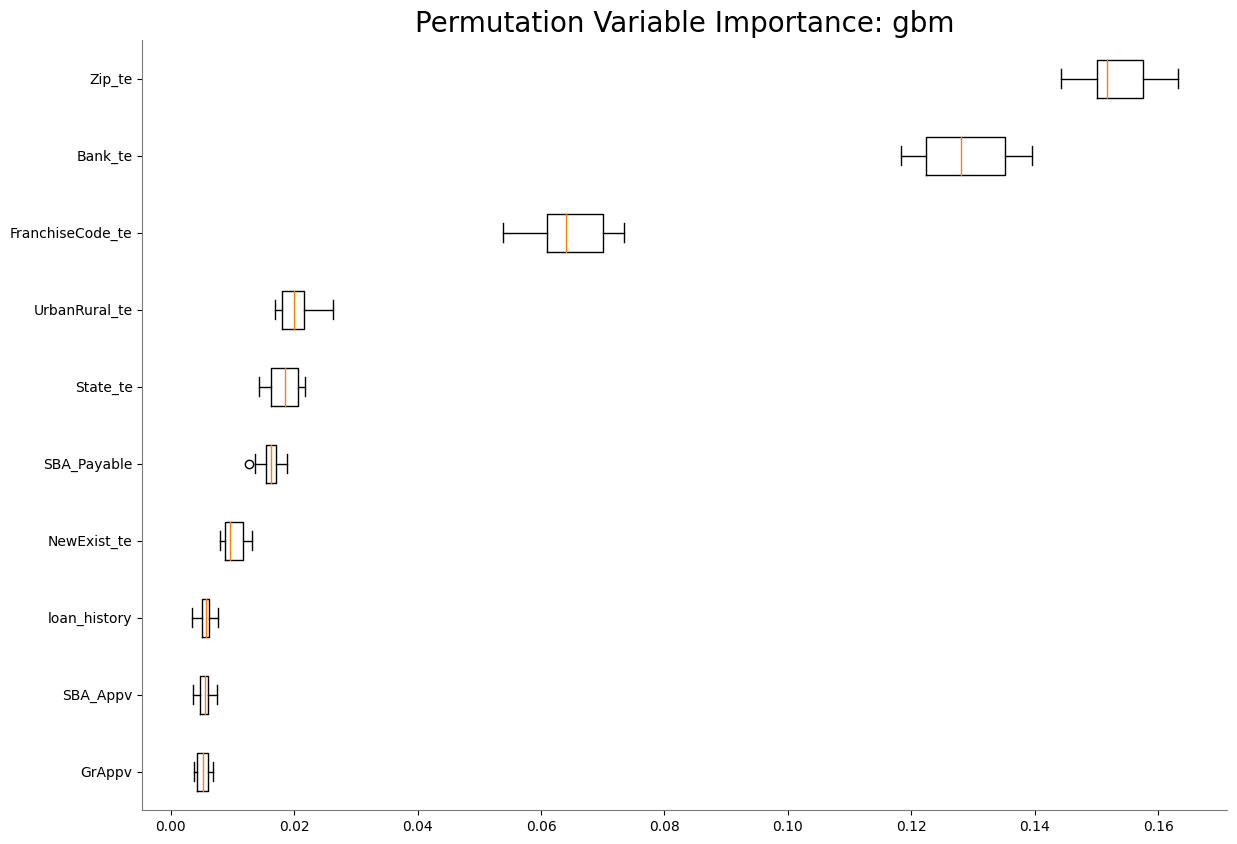

Variable,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,Run 10,Run 11,Run 12,Run 13,Run 14,Run 15
Zip_te,0.1573860,0.1501405,0.1632098,0.1511094,0.1465850,0.1577498,0.1563253,0.1504323,0.1442122,0.1599107,0.1516345,0.1575477,0.1460128,0.1517447,0.1500599
Bank_te,0.1378379,0.1313083,0.1374181,0.1255885,0.1289239,0.1222843,0.1394793,0.1280735,0.1225575,0.1250938,0.1361718,0.1182590,0.1183586,0.1342140,0.1184128
FranchiseCode_te,0.0640979,0.0665012,0.0571572,0.0613106,0.0688821,0.0710745,0.0602456,0.0725039,0.0608599,0.0630339,0.0609618,0.0734955,0.0684481,0.0721763,0.0538214
UrbanRural_te,0.0223626,0.0185934,0.0247381,0.0195342,0.0200108,0.0208030,0.0247834,0.0169070,0.0199440,0.0262400,0.0175961,0.0171924,0.0173587,0.0201917,0.0209765
SBA_Payable,0.0179497,0.0153980,0.0127114,0.0164938,0.0162191,0.0149626,0.0173180,0.0158988,0.0162949,0.0181159,0.0168109,0.0188519,0.0156382,0.0136658,0.0163822
State_te,0.0170562,0.0172580,0.0143550,0.0185789,0.0208049,0.0202229,0.0154190,0.0217028,0.0178360,0.0184546,0.0151462,0.0215216,0.0207324,0.0204445,0.0144827
NewExist_te,0.0090274,0.0113240,0.0085294,0.0096749,0.0105270,0.0104543,0.0082603,0.0120594,0.0090165,0.0089793,0.0087617,0.0128097,0.0131514,0.0120365,0.0079164
DisbursementGross,0.0061341,0.0044409,0.0049722,0.0040783,0.0059225,0.0054902,0.0048903,0.0025856,0.0063176,0.0039682,0.0050933,0.0047793,0.0041204,0.0061964,0.0042319
loan_history,0.0057911,0.0049222,0.0076321,0.0066689,0.0050233,0.0062095,0.0056182,0.0033951,0.0060826,0.0047979,0.0051010,0.0056632,0.0062449,0.0062258,0.0061233
GrAppv,0.0048283,0.0060559,0.0050874,0.0043696,0.0068737,0.0040075,0.0053429,0.0038154,0.0039719,0.0038564,0.0052987,0.0064124,0.0059824,0.0063309,0.0055874


In [73]:
# calculate importance
permutation_varimp = gbm_model.permutation_importance(train_te, use_pandas=True)
# plot permutation importance (bar plot)
gbm_model.permutation_importance_plot(train_te)
# plot permutation importance (box plot)
gbm_model.permutation_importance_plot(train_te, n_repeats=15)

In [74]:
perf = gbm_model.model_performance(valid)
print(perf.auc())

0.6945893469570389


# Model Tuning for the H2O GBM Model

In [75]:
# Establishing a baseline performance
#We only provide the required parameters, everything else is default
gbm = H2OGradientBoostingEstimator()
gbm.train(x=variables, y=response, training_frame=train)
## Show a detailed model summary
print(gbm)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1683523369905_532


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          32814                  5            5            5             24            32            30.78

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1175007693518087
RMSE: 0.3427838522331656
LogLoss: 0.3768638040858953
Mean Per-Class Error: 0.29004427491548856
AUC: 0.7966132736993192
AUCPR: 0.48151872819097885
Gini: 0.5932265473986384

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.229

In [76]:
## Get the AUC on the validation set
perf = gbm.model_performance(valid)
print(perf.auc())

0.7904845952606784


In [77]:
# Hyperparameter Search
hyper_params_tune = {'max_depth' : list(range(5,10,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 160,  ## limit the runtime to 60 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-3
                   }

In [78]:
gbm_tune = H2OGradientBoostingEstimator(distribution='bernoulli',
                    ## more trees is better if the learning rate is small enough 
                    ## here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    ## smaller learning rate is better
                    ## since we have learning_rate_annealing, we can afford to start with a 
                    #bigger learning rate
                    learn_rate=0.05,
                    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
                    ## (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    ## score every 10 trees to make early stopping reproducible 
                    #(it depends on the scoring interval)
                    score_tree_interval = 10,
                    ## fix a random number generator seed for reproducibility
                    seed = 1234,
                    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    #5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)

In [79]:
tune_grid = H2OGridSearch(gbm_tune, hyper_params = hyper_params_tune,
                                    grid_id = 'tune_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
tune_grid.train(x=predictors, 
           y=response,
           ## early stopping based on timeout
           max_runtime_secs = 3600, 
           training_frame = train_te,
           validation_frame = valid_te)
print(tune_grid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by increasing logloss
    col_sample_rate    col_sample_rate_change_per_level    col_sample_rate_per_tree    histogram_type    max_depth    min_rows    min_split_improvement    nbins    nbins_cats    sample_rate    model_ids          logloss
--  -----------------  ----------------------------------  --------------------------  ----------------  -----------  ----------  -----------------------  -------  ------------  -------------  -----------------  ---------
    0.34               1.09                                0.27                        UniformAdaptive   8            8           0                        128      2048          0.41           tune_grid_model_3  0.397349
    0.63               0.98                                0.88                        QuantilesGlobal   9            1           0.0001                   512      256           0.

# Model With best parameters

In [80]:
gbm_model_best = H2OGradientBoostingEstimator(ntrees = 10000,                                                            
  ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  col_sample_rate=0.34, 
  col_sample_rate_change_per_level=1.09,    
  col_sample_rate_per_tree=0.27,
  max_depth=8,
  min_rows=8,   
  nbins=128,
  nbins_cats=2048,    
  sample_rate=0.41)

gbm_model_best.train(x=predictors_gbm, y=response, training_frame=train_te, validation_frame=valid_te)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1683523369905_1046


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    10000              10000                       1.52461e+06            0            9            0.198         1             426           7.0337

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09399854626734043
RMSE: 0.30659182354939024
LogLoss: 0.30546047722478287
Mean Per-Class Error: 0.22320812922652522
AUC: 0.8849760563259589
AUCPR: 0.6677714254217482
Gini: 0.7699521126519178

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.288912032912311
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      263720  32087  0.1085   (32087.0/295807.0)
1      21307   41742  0.3379   (21307.0/63049.0)
Total  285027  73829  0.1488   (53394.0/358856.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288912     0.609915  209
max f2                       0.163736     0.703315  274
max f0point5                 0.45866      0.63973   142
max accuracy                 0.455825     0.871648  143
max precision                0.988856     1         0
max recall                   0.00592783   1         393
max specificity              0.988856     1         0
max absolute_mcc             0.304636     0.521636  202
max min_per_class_accuracy   0.198459     0.798994  255
max mean_per_class_accuracy  0.18223      0.799902  264
max tns                      0.988856     295807    0
max fns                      0.988856     63015     0
max fps                      0.000750844  295807    399
max tps                      0.00592783   63049     393
max tnr                      0.988856     1         0
max fnr                      0.988856     0.999461  0
max fpr                      0.000750844  1         399
max tpr                      0.00592783   1         393

Gains/Lift Table: Avg response rate: 17.57 %, avg score: 17.57 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100012                   0.842674           5.53787     5.53787            0.972973         0.898421    0.972973                    0.898421            0.0553855       0.0553855                  453.787   453.787            0.0550576
2        0.0200025                   0.763383           5.22863     5.38325            0.91864          0.800927    0.945807                    0.849674            0.0522927       0.107678                   422.863   438.325            0.106363
3        0.0300009                   0.700488           4.88585     5.21748            0.858417         0.73069     0.916682                    0.81002             0.0488509       0.156529                   388.585   421.748            0.153497
4        0.0400021                   0.650716           4.54036     5.04819            0.797715         0.675219    0.886938                    0.776317            0.0454091       0.201938                   354.036   404.819            0.196451
5        0.0500006                   0.607367           4.24181     4.88694            0.745262

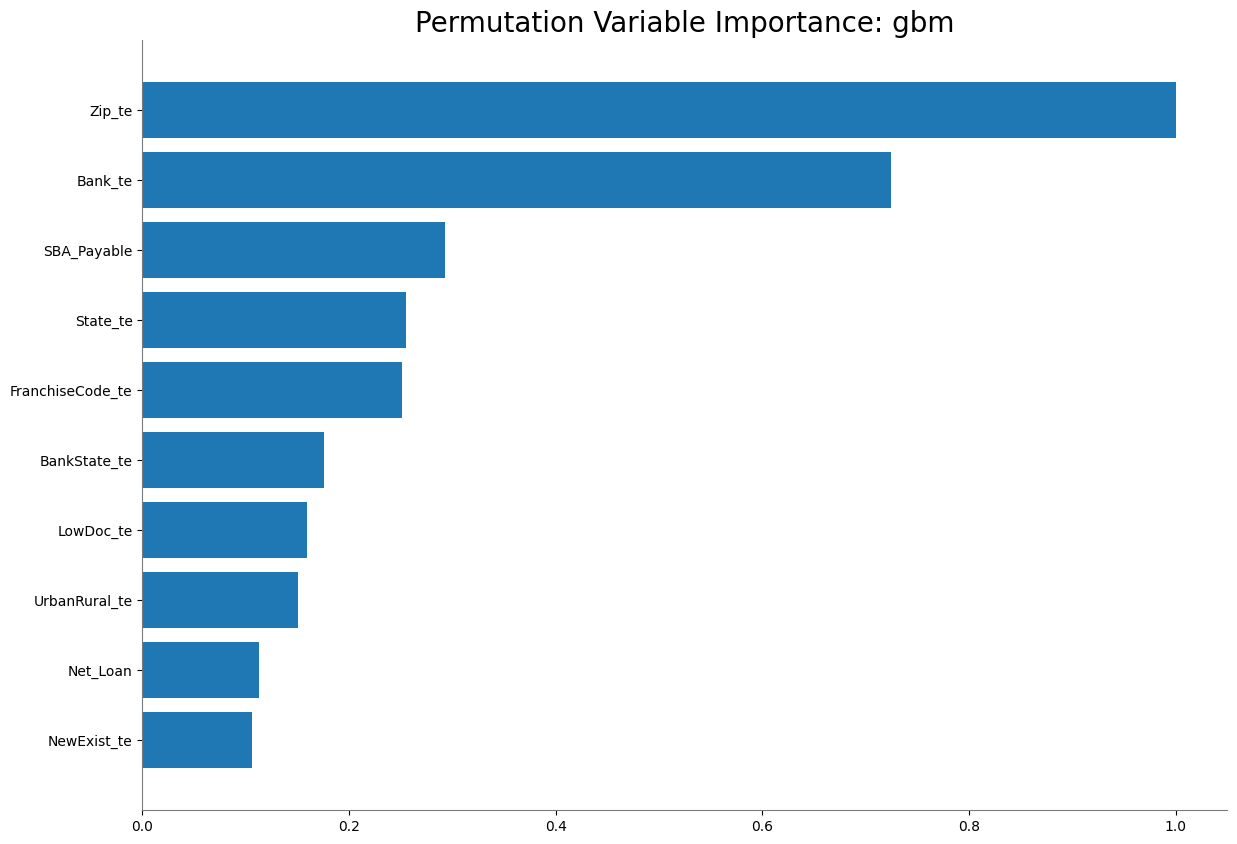

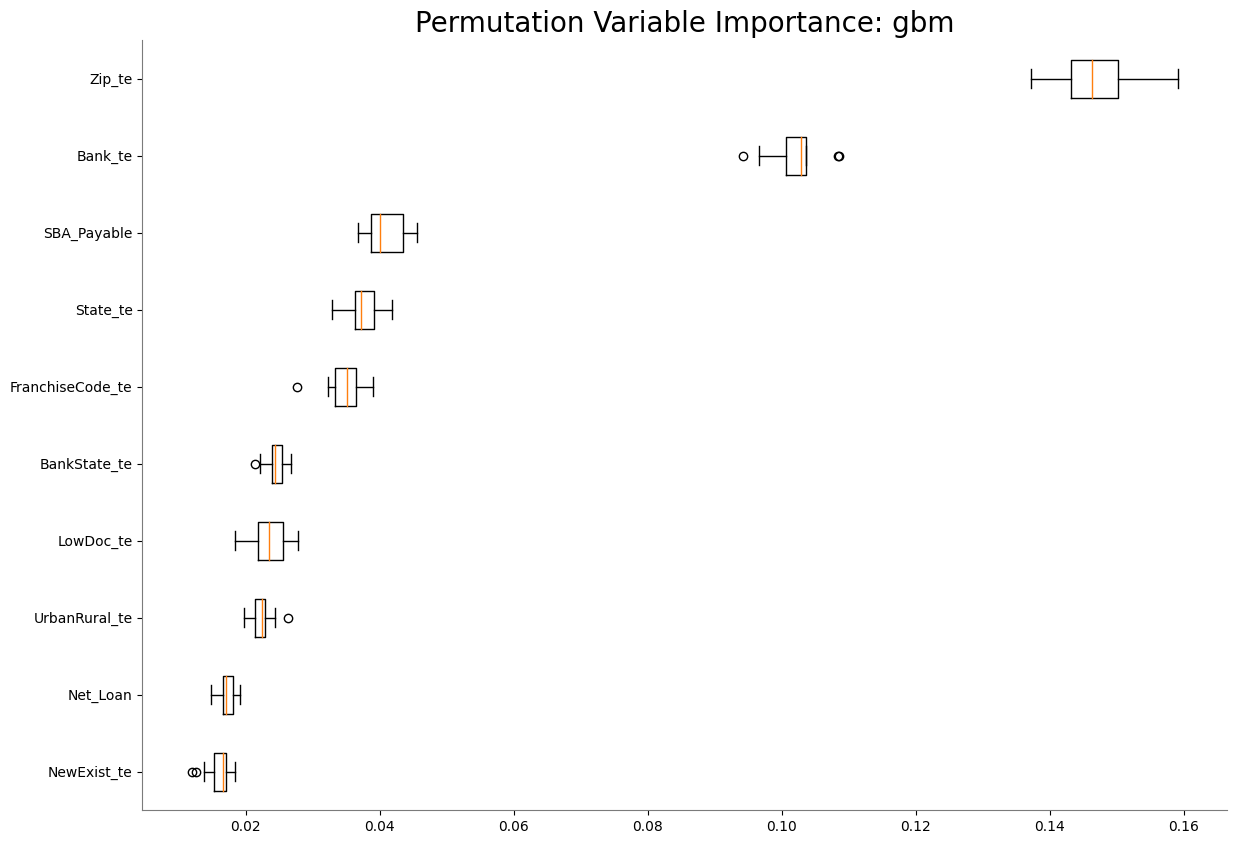

Variable,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,Run 10,Run 11,Run 12,Run 13,Run 14,Run 15
Zip_te,0.1462860,0.1475997,0.1474322,0.1436773,0.1427465,0.1500344,0.1439788,0.1506388,0.1503360,0.1508899,0.1413602,0.1372101,0.1434931,0.1406930,0.1591181
Bank_te,0.1085597,0.1033276,0.1006352,0.1007277,0.0965775,0.1084507,0.1019879,0.1023607,0.1029701,0.1028572,0.0980843,0.1036229,0.0941942,0.1036075,0.1035064
SBA_Payable,0.0397286,0.0431597,0.0433533,0.0400214,0.0420356,0.0400109,0.0438326,0.0367378,0.0385457,0.0455125,0.0443052,0.0379618,0.0388005,0.0436407,0.0383173
State_te,0.0350353,0.0366170,0.0418674,0.0328818,0.0361147,0.0371912,0.0367700,0.0370972,0.0396092,0.0354353,0.0395495,0.0391587,0.0389491,0.0391249,0.0374423
FranchiseCode_te,0.0327947,0.0361080,0.0356381,0.0276557,0.0354685,0.0390193,0.0367154,0.0341553,0.0345544,0.0337505,0.0374446,0.0324804,0.0350613,0.0377451,0.0323203
BankState_te,0.0235477,0.0247973,0.0244153,0.0243595,0.0257733,0.0213960,0.0242333,0.0260367,0.0268203,0.0232302,0.0254178,0.0221238,0.0252921,0.0245361,0.0242161
UrbanRural_te,0.0228569,0.0197996,0.0202740,0.0228384,0.0197831,0.0243501,0.0227001,0.0212719,0.0263657,0.0219369,0.0216310,0.0224116,0.0219799,0.0238457,0.0229026
LowDoc_te,0.0200930,0.0214167,0.0250553,0.0184315,0.0270291,0.0234794,0.0204935,0.0264673,0.0277816,0.0255730,0.0222589,0.0235155,0.0236915,0.0231751,0.0254367
SBA_Appv,0.0171055,0.0165168,0.0141097,0.0132410,0.0136092,0.0125845,0.0119184,0.0148261,0.0154268,0.0116761,0.0111584,0.0109683,0.0117741,0.0133867,0.0165361
Net_Loan,0.0169683,0.0160795,0.0171377,0.0155423,0.0182852,0.0168333,0.0183191,0.0147847,0.0191103,0.0171058,0.0168100,0.0181644,0.0181312,0.0174250,0.0164375


In [81]:
# calculate importance
permutation_varimp_best = gbm_model_best.permutation_importance(train_te, use_pandas=True)
# plot permutation importance (bar plot)
gbm_model_best.permutation_importance_plot(train_te)
# plot permutation importance (box plot)
gbm_model_best.permutation_importance_plot(train_te, n_repeats=15)

In [83]:
# the f1 score on the validation data
f1_score_gbm_best = gbm_model_best.F1(valid=True)
print('F1 score on validation set:', f1_score_gbm_best)

F1 score on validation set: [[0.2259880473244425, 0.45274759033831263]]


# Model Interpretability

In [84]:
!pip uninstall numba
!pip install shap==0.40.0

^C



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
!pip install shap==0.40.0


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
# # Shapely values to get a Shapley summary graph
def examine_all_reason_codes(data, model):
    
    shap_contribs = model.predict_contributions(data)
    
    col_mapping = {}
    for i in data.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.summary_plot(shap_contribs[shap_cols].values, 
                             X[shap_cols].values,
                             feature_names=shap_cols
                            )

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


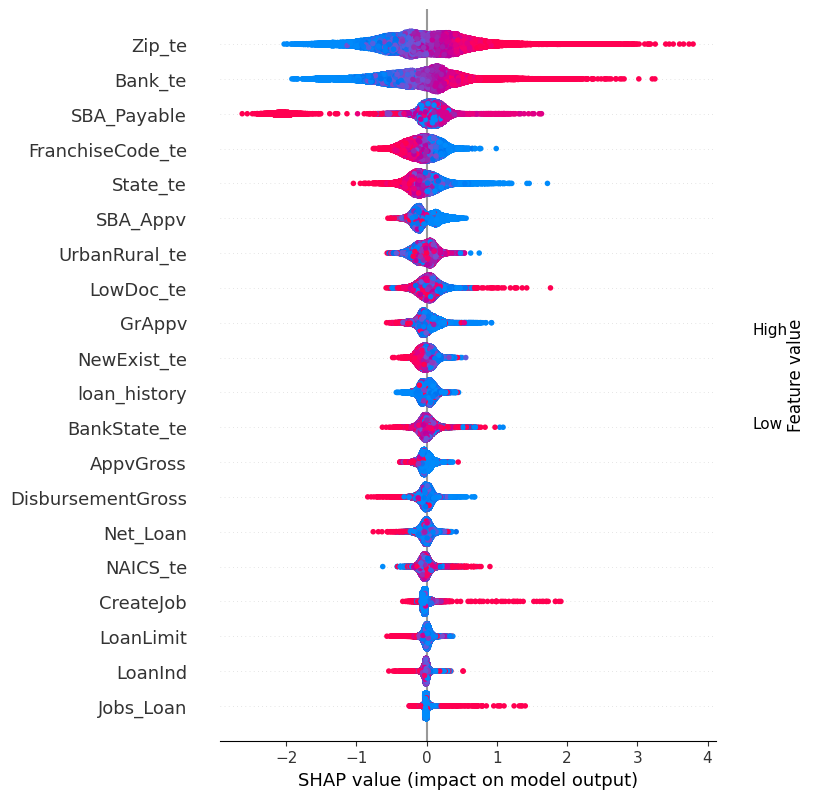

In [87]:
# # Observe the shapely values for the 1st 50000 predictions
examine_all_reason_codes(train_te[0:50000,:], gbm_model_best)

In [ ]:
''' Through shapely values we try to understand how much a feature contributes in predicting the model on an average under various coalitions.
plot displays a horizontal axis representing the impact of each feature on the prediction (positive or negative), and a vertical axis
representing the importance of each feature.

The length of the horizontal bar for each of the variables depicts the magnitude of the contribution.
From the above plot we can conclude that
1. Zip_te, Bank_te and SBA_Payable have the most contributions in determing the MIS_Status.
2. Loan_Limit , LoanInd have very minimum contribution. 
This implies that a change in the Zip_te, Bank_te and SBA_Payable will result in highest residual in predicting the MIS_Status of the loan.

In our model,  Additivity property guarantees that for a feature value, calculate the Shapley value for each tree individually, average them, 
and get the Shapley value for the feature value.'''

<AxesSubplot: title={'center': 'Zip_te'}, xlabel='[MIS_Status]'>

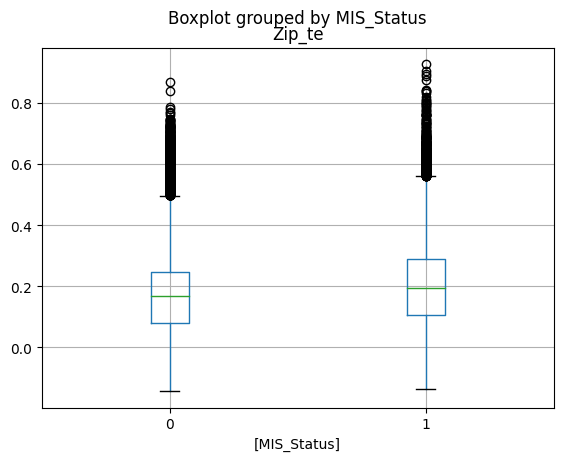

In [107]:
# # Check individual feature interactions
valid_te[["Zip_te",response]].as_data_frame(use_pandas=True).boxplot(by=response)

<AxesSubplot: title={'center': 'SBA_Payable'}, xlabel='[MIS_Status]'>

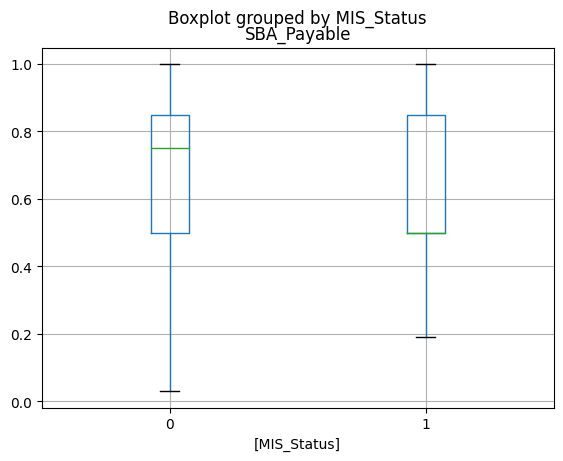

In [89]:
# # Check individual feature interactions
train_te[["SBA_Payable",response]].as_data_frame(use_pandas=True).boxplot(by=response)

<AxesSubplot: title={'center': 'Bank_te'}, xlabel='[MIS_Status]'>

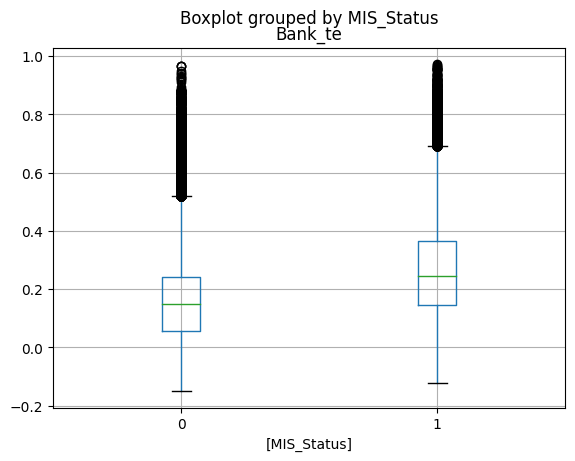

In [90]:
# # Check individual feature interactions
train_te[["Bank_te",response]].as_data_frame(use_pandas=True).boxplot(by=response)

In [91]:
# # Shapely values to get a Shapley summary graph of individual records
def examine_indiv_reason_codes(record, model, use_matplotlib=True):
    
    shap_contribs = model.predict_contributions(record)
    
    col_mapping = {}
    for i in record.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = record.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.force_plot(bias_term, 
                           shap_contribs[shap_cols].values, 
                           X[shap_cols].values, 
                           shap_cols,
                           link="logit",
                           matplotlib=use_matplotlib
                          )

In [92]:
# load JS visualization code to notebook
# # Shapely values to get a Shapley summary graph of the 1st record
shap.initjs()
examine_indiv_reason_codes(train_te[1, :], gbm_model_best, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [ ]:
''' in the above plot Risk increasing loans being charged off is low(0.06). MIS_Status increasing effects such 
as Zip_te and bank_te are offset by decreasing effects such as SBA_Appv.'''

In [93]:
# load JS visualization code to notebook
# # Shapely values to get a Shapley summary graph of the 2nd record
shap.initjs()
examine_indiv_reason_codes(train_te[2, :], gbm_model_best, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [ ]:
''' For the second record we observe the probability of MIS_Status=1 is low. SBA_payable increase the predicted probability of MIS_status=1 '''

In [94]:
# load JS visualization code to notebook
# # Shapely values to get a Shapley summary graph of the 3rd record
shap.initjs()
examine_indiv_reason_codes(train_te[3, :], gbm_model_best, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [ ]:
''' For the 3rd record we observe the probability of MIS_Status=1 is low. Zip_te increase the predicted probability of MIS_status=1 while
FranchiseCode_te lowers the effect'''

In [95]:
# load JS visualization code to notebook
# # Shapely values to get a Shapley summary graph of the 50000th record
shap.initjs()
examine_indiv_reason_codes(train_te[50000, :], gbm_model_best, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [96]:
# load JS visualization code to notebook
# # Shapely values to get a Shapley summary graph of the 49999th record
examine_indiv_reason_codes(train_te[49999, :], gbm_model_best, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


# Running the best model to predict the MIS_Status

In [97]:
# # Running the model with the best parameters and check the performance on the test data
best_params = {"verbose": -1,"objective":"binary","metric":"auc","learning_rate": 0.1,"num_leaves": 70,"max_depth": 11,"min_data_in_leaf": 500,
              "bagging_fraction": 0.9,"bagging_freq": 5,"feature_fraction": 0.9,"is_unbalance": True}
train_data = lgb.Dataset(data=X_tr, label=Y_tr, params={"verbose":-1})
test_data = lgb.Dataset(data=X_v, label=Y_v, params={"verbose":-1})
best_lgb_model = lgb.train(params=best_params,train_set=train_data)
y_pred_prob_best = best_lgb_model.predict(X_tst)
y_pred_best = (y_pred_prob_best > 0.5).astype(int)
f1_tst_best = f1_score(Y_tst, y_pred_best,average='macro')
print("F1 score on validation data:", f1_tst_best)

F1 score on validation data: 0.6439062394381356


In [98]:
y_pred_prob_best = best_lgb_model.predict(X_tr)
y_pred_best = (y_pred_prob_best > 0.5).astype(int)
f1_tst_best = f1_score(Y_tr, y_pred_best,average='macro')
print("F1 score on train data:", f1_tst_best)

F1 score on train data: 0.6823060193024447


# Save the artefacts for the scoring function

In [109]:
ohe_columns

['FranchiseCode_N',
 'FranchiseCode_Y',
 'UrbanRural_Rural',
 'UrbanRural_Undefined',
 'UrbanRural_Urban',
 'LowDoc_0',
 'LowDoc_1',
 'LowDoc_A',
 'LowDoc_C',
 'LowDoc_N',
 'LowDoc_R',
 'LowDoc_S',
 'LowDoc_Y']

In [99]:
# Saving the artefacts for the scoring function
artifacts_dict = {
        "original_columns":data_cols,# Columns to consider from the test dataset
        "model": best_lgb_model,# the LightGBM model with the best parameters
        "woe_cols": woe_te_cols,# columns to perform WOE encoding on the test data
        "label_encoder":le, # label encoder used for feature creation
        "woe_encoder":woe_encoder,# WOE encoder used to transform categorical to numerical variables
        "ohe_columns": cat_columns,# one hot encoded columns
        "threshold": best_threshold,# store the best threshold to determine the final label for MIS_Status
        "drop_from_data": drop_from_data,#Columns to drop and not consider from the test data
        "col_remove_dollar":col_remove_dollar,# Columns with values prefixed by '$'
        "columns_to_score":parameters # parameters to predict the test dataset's target variable
    }

In [100]:
# Creation of the pickle file
artifacts_dict_file = open("artifacts_proj2_file.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_dict_file)
artifacts_dict_file.close()